In [1]:
using Plots
using Distributions
using LinearAlgebra
using ProgressMeter

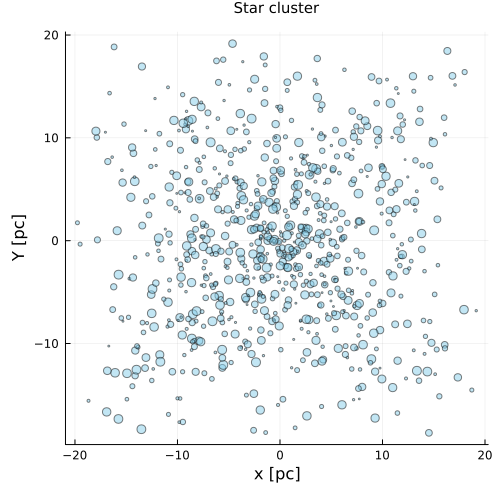

In [27]:
n = 800
# theta = rand(Uniform(0.0, 360.0), n, 1) 
# phi = rand(Uniform(0.0, 360.0), n, 1)
# r = rand(Uniform(0.0, 50.0), n, 1)
# x = r .* sin.(theta) .* cos.(phi)
# y = r .* sin.(theta) .* sin.(phi)
# z = r .* cos.(theta)

r = 20 .* sqrt.(rand(n, 1))
x = r .* (rand(n, 1) .* 2.0 .- 1.0)
y = r .* (rand(n, 1) .* 2.0 .- 1.0)
z = r .* (rand(n, 1) .* 2.0 .- 1.0)
positions = hcat(x, y, z)
masses = rand(Uniform(1.0, 5.0), n, 1)
velocities = rand(Uniform(-2,2), n, 3)
scatter(positions[:,1], positions[:,2], legend=false, size=(500,500), color=:skyblue, alpha = 0.5, 
    ms=masses, title="Star cluster",titlefontsize=10, xlabel="x [pc]", ylabel="Y [pc]")

In [28]:
function get_kinetic_energy(velocities::Matrix, masses::Matrix)
    k_e = 0.5 * sum(sum.( masses .* velocities.^2 ))
    return k_e
end

function get_potential_energy(positions::Matrix, masses::Matrix, G::Float64, e::Float64)
    x = positions[:,1]
    y = positions[:,2]
    z = positions[:,3]
    dx = transpose(x) .- x
    dy = transpose(y) .- y
    dz = transpose(z) .- z
    
    r = ( dx.^2 .+ dy.^2 .+ dz.^2 .+ e.^2 ).^(-0.5)
    p_e = - G * sum( sum.( triu( *(masses, transpose(masses)) .* r, 1) ) )
    return p_e
end

get_potential_energy (generic function with 1 method)

In [29]:
function get_acceleration(positions::Matrix, masses::Matrix, G::Float64, e::Float64)
    
    x = positions[:,1]
    y = positions[:,2]
    z = positions[:,3]
    
    dx = transpose(x) .- x
    dy = transpose(y) .- y
    dz = transpose(z) .- z

    r3_2 = ( dx.^2 .+ dy.^2 .+ dz.^2 .+ e.^2 ).^(-1.5)
    
    ax = *((dx .* r3_2), masses) .* G
    ay = *((dy .* r3_2), masses) .* G
    az = *((dz .* r3_2), masses) .* G
    
    return hcat(ax, ay, az)
end

get_acceleration (generic function with 1 method)

In [5]:
#get_acceleration(positions, masses, 1.0, 0.1)

In [30]:
function get_jerk(positions::Matrix, velocities::Matrix, masses::Matrix, G::Float64, e::Float64)
    x = positions[:,1]
    y = positions[:,2]
    z = positions[:,3]
    dx = transpose(x) .- x
    dy = transpose(y) .- y
    dz = transpose(z) .- z
    
    vx = velocities[:,1]
    vy = velocities[:,2]
    vz = velocities[:,3]
    dvx = transpose(vx) .- vx
    dvy = transpose(vy) .- vy
    dvz = transpose(vz) .- vz
    
    r3_2 = ( dx.^2 .+ dy.^2 .+ dz.^2 .+ e.^2 ).^(-1.5)
    r5_2 = ( dx.^2 .+ dy.^2 .+ dz.^2 .+ e.^2 ).^(-2.5)
    
    ax_dot = *((dvx .* r3_2 .- 3 .* dot.(dvx, dx) .* dx .* r5_2), masses) .* G
    ay_dot = *((dvy .* r3_2 .- 3 .* dot.(dvy, dy) .* dy .* r5_2), masses) .* G
    az_dot = *((dvz .* r3_2 .- 3 .* dot.(dvz, dz) .* dz .* r5_2), masses) .* G
    return hcat(ax_dot, ay_dot, az_dot)
end

get_jerk (generic function with 1 method)

In [31]:
function evolve_hermite(positions::Matrix, velocities::Matrix, masses::Matrix, t_end::Float64, dt::Float64)
    
    N = length(masses)
    G, e = 1.0, 0.1
    Nt = Int(ceil(t_end / dt))
    # velocities to center of mass frame
    velocities -= mean(masses .* velocities; dims=3) ./ mean(masses)
    
    # save initial positions and velocities
    pos = ones( (N, 3, Nt + 1) )
    pos[:,:,1] = positions # x_0
    vel = ones( (N, 3, Nt + 1) )
    vel[:,:,1] = velocities # v_0
    
    # init_energies
    Kinetic = ones(Nt + 1)
    Potential = ones(Nt + 1)
    Kinetic[1] = get_kinetic_energy(vel[:,:,1], masses)
    Potential[1] = get_potential_energy(pos[:,:,1], masses, G, e)
    t = 0.0
    
    @showprogress "Evolving Hermite..." for i in 2:Nt
        
        #initial acceleration and jerk
        acc0 = get_acceleration(pos[:,:,i-1], masses, G, e)
        jerk0 = get_jerk(pos[:,:,i-1], vel[:,:,i-1], masses, G, e)
        
        # predict initial positions and velocities
        vel_pred = vel[:,:,i-1] .+  dt .*( acc0 .+ (dt .* 0.5 .* jerk0) )
        pos_pred = pos[:,:,i-1] .+  dt .* ( vel[:,:,i-1] .+ (dt .* 0.5) .* (acc0 .+ (dt ./ 3) .* jerk0) )
        
        # update acceleration and jerk
        acc1 = get_acceleration(pos_pred, masses, G, e)
        jerk1 = get_jerk(pos_pred, vel_pred, masses, G, e)
        
        # compute a2 and a3
        a2 = ( .- 6.0 .* (acc0 .- acc1) .- dt .* (4 .* jerk0 .+ 2 .* jerk1)) ./ dt.^2
        a3 = ( .- 12.0 .* (acc0 .- acc1) .- 6.0 .* dt .* (jerk0 .+ jerk1)) ./ dt.^3
        
        # predict r1 and v1
        vel[:,:,i] = vel_pred .+ a2 .* dt.^3 ./ 4.0 .+ a3 .* dt.^4 ./ 24.0
        pos[:,:,i] = pos_pred .+ a2 .* dt.^4 ./ 24.0 .+ a3 .* dt.^5 ./ 120.0
        
        # save energies
        Kinetic[i] = get_kinetic_energy(vel[:,:,i], masses)
        Potential[i] = get_potential_energy(pos[:,:,i], masses, G, e)
        t += dt
        sleep(0.01)
    end
    
    return pos[:,:,1:end-1], Kinetic[1:end-1], Potential[1:end-1]
end

evolve_hermite (generic function with 1 method)

In [32]:
function evolve_verlet(positions::Matrix, velocities::Matrix, masses::Matrix, t_end::Float64, dt::Float64)
    
    N = length(masses)
    G, e = 1.0, 0.1
    # velocities to center of mass frame
    velocities -= mean(masses .* velocities; dims=3) ./ mean(masses)
    
    #initial
    acceleration = get_acceleration(positions, masses, G, e)
    Nt = Int(ceil(t_end / dt))
    
    # to save K, P and positions
    save_K = ones(Nt+1)
    save_P = ones(Nt+1)
    save_positions = ones( (N, 3, Nt+1) )
    
    # init_energies
    save_K[1] = get_kinetic_energy(velocities, masses)
    save_P[1] = get_potential_energy(positions, masses, G, e)
    
    save_positions[:,:,1] = positions # x_0
    save_positions[:,:,2] = positions .+ velocities .* dt .+ 0.5 .* acceleration .* dt.^2 # x_1
    t = 0.0
    
    @showprogress "Evolving verlet..." for i in 2:Nt
        
        # update acceleration
        acceleration = get_acceleration(save_positions[:,:,i], masses, G, e)
        velocities += acceleration .* dt ./ 2.0
        save_positions[:,:,i+1] = 2 .* save_positions[:,:,i] - save_positions[:,:,i-1] .+ acceleration .* dt.^2
        
        save_K[i] = get_kinetic_energy(velocities, masses)
        save_P[i] = get_potential_energy(save_positions[:,:,i], masses, G, e)
        t += dt
        sleep(0.01)
    end
    
    return save_positions[:,:,1:end-1], save_K[1:end-1], save_P[1:end-1]
end

evolve_verlet (generic function with 1 method)

In [33]:
function evolve_leapfrog(positions::Matrix, velocities::Matrix, masses::Matrix, t_end::Float64, dt::Float64)
    
    N = length(masses)
    G, e = 1.0, 0.1
    Nt = Int(ceil(t_end / dt))
    # velocities to center of mass frame
    velocities -= mean(masses .* velocities; dims=3) ./ mean(masses)
    
    #initial
    acceleration = get_acceleration(positions, masses, G, e)
    
    # to save K, P and positions
    save_K = ones(Nt+1)
    save_P = ones(Nt+1)
    save_positions = ones( (N, 3, Nt+1) )
    
    # init_energies
    save_K[1] = get_kinetic_energy(velocities, masses)
    save_P[1] = get_potential_energy(positions, masses, G, e)
    save_positions[:,:,1] = positions # x_1
    t = 0.0
    
    @showprogress "Evolving leapfrog..." for i in 1:Nt
        
        velocities += acceleration .* dt ./ 2.0
        positions += velocities .* dt
        
        # update acceleration
        acceleration = get_acceleration(positions, masses, G, e)
        velocities += acceleration .* dt ./ 2.0
        
        # save
        save_positions[:,:,i+1] = positions
        save_K[i] = get_kinetic_energy(velocities, masses)
        save_P[i] = get_potential_energy(save_positions[:,:,i], masses, G, e)
        t += dt
        sleep(0.01)
    end
    
    return save_positions[:,:,1:end-1], save_K[1:end-1], save_P[1:end-1]
end

evolve_leapfrog (generic function with 1 method)

In [34]:
t_end, t_step = 10.0, 0.01
#pos, k, p = evolve_leapfrog(positions, velocities, masses, t_end, t_step);
#pos, k, p = evolve_verlet(positions, velocities, masses, t_end, t_step);
pos, k, p = evolve_hermite(positions, velocities, masses, t_end, t_step);
size(pos)

Evolving Hermite... 100%|████████████████████████████████| Time: 0:04:27


(800, 3, 1000)

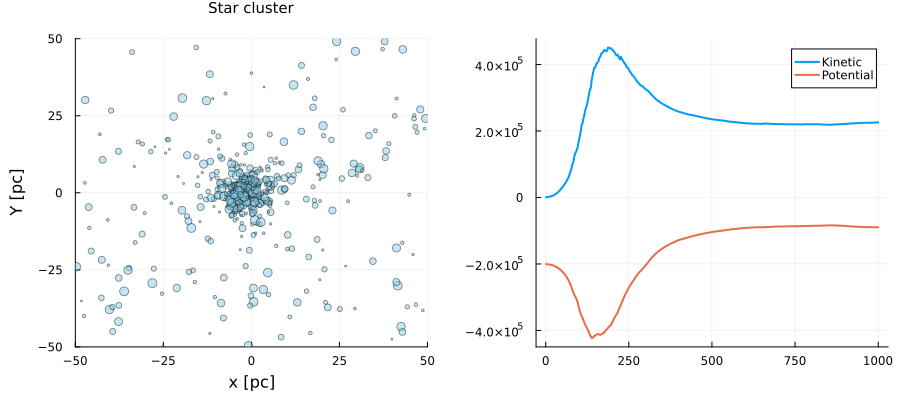

In [37]:
#p1 = scatter(pos[:,1,end], pos[:,2,end], legend=false, size=(300,300), color=:green, alpha = 0.5, ms=3)
#plot(p1, layout=(1,2), size=(800,300))
p1 = scatter(pos[:,1,end], pos[:,2,end], legend=false, xlims=(-50,50),ylims=(-50,50), color=:skyblue, alpha = 0.5, 
    ms=masses, title="Star cluster",titlefontsize=10, xlabel="x [pc]", ylabel="Y [pc]", margin=5Plots.mm)
#p2 = plot([k, p, k+p], label=["Kinetic" "Potential" "Total energy"], size=(400,300), alpha = 1.5, lw=2)
p2 = plot([k, p], label=["Kinetic" "Potential"], alpha = 1.5, lw=2)
plot(p1, p2, layout=(1,2), size=(900,400))

In [38]:
anim = @animate for i in 1:size(pos)[3]
    scatter(pos[:,1,i], pos[:,2,i], legend=false, size=(400,400), color=:skyblue, alpha = 0.5, ms=masses,
    title="Star cluster",titlefontsize=10, xlabel="x [pc]", ylabel="y [pc]", margin=0.5Plots.mm)
    xlims!(-40,40)
    ylims!(-40,40)
end
#gif(anim, "nbody_leapfrog.gif", fps = 30);
#gif(anim, "nbody_verlet.gif", fps = 30);
gif(anim, "nbody_hermite.gif", fps = 30);

[ Info: Saved animation to /home/steven/Documents/JuliaNotebooks/nbody_hermite.gif
